# Comut plots

This notebook generates the plots in Fig. 1b and Extended Data Fig. 2a.

# Setup

In [2]:
from comut import comut
import pandas as pd
import re
import os
import matplotlib
import matplotlib.pyplot as plt
import palettable
import pickle
import numpy as np
import itertools
from matplotlib.patches import Patch

In [4]:
oncopanel_variants_path = "../data/icb_variants_standardized.tsv" 
patient_sheet_path = "../data/participant_cohort_sheet.tsv" 
sample_sheet_path = "../data/sample_cohort_sheet.tsv" 
wes_variants_path = "../data/muts_cnas_combined.pkl" 
tmb_path = "../data/combined_tmb.tsv" 

oncopanel_variants = pd.read_csv(oncopanel_variants_path, sep = '\t')
oncopanel_variants.replace({'GBM.ICB-3-14.637.Post.FFbank': 'GBM.ICB-3-14.233.Pre'}, inplace = True)
patient_sheet = pd.read_csv(patient_sheet_path, sep = '\t')
sample_sheet = pd.read_csv(sample_sheet_path, sep = '\t')
wes_variants = pd.read_pickle(wes_variants_path)
tmb = pd.read_csv(tmb_path, sep = '\t')

# Participant comut

In [5]:
s_with_wes = sample_sheet.loc[sample_sheet['usable_wes'] & (sample_sheet['tumor_normal'] == 'tumor')]
s_with_rna = sample_sheet.loc[sample_sheet['usable_rnaseq'] & (sample_sheet['tumor_normal'] == 'tumor')]
s_with_oncopanel = sample_sheet.loc[sample_sheet['usable_oncopanel']]

patient_sheet_counts = patient_sheet.set_index('participant_id_legacy').join(
    s_with_wes.groupby(['participant_id_legacy', 'pre_post']).size().unstack().fillna(0).rename(columns={'Pre': 'WES_pre_num', 'Post': 'WES_post_num'})).join(
    s_with_rna.groupby(['participant_id_legacy', 'pre_post']).size().unstack().fillna(0).rename(columns={'Pre': 'RNA_pre_num', 'Post': 'RNA_post_num'})).join(
    s_with_oncopanel.groupby(['participant_id_legacy', 'pre_post']).size().unstack().fillna(0).rename(columns={'Pre': 'OncoPanel_pre_num'}))

sorted_patient_list = patient_sheet_counts.sort_values(['ICB for Newly diagnosed', 'osicb'], ascending = [True, False]).index.tolist()

patient_sheet['sample'] = patient_sheet['participant_id_legacy']

In [6]:
pt_comut = comut.CoMut()
pt_comut.samples = sorted_patient_list

absent_mapping = {'facecolor':'none', 'edgecolor':'#D7CFBF', 'linewidth': 2}
baseline_color = 'lightgray'

# Number of samples
sample_num_colors = palettable.scientific.sequential.LaJolla_4.mpl_colors
sample_num_mapping = {'0': baseline_color, '1': sample_num_colors[1], '2+': sample_num_colors[2]}

sample_num_columns = ['RNA_post_num', 'RNA_pre_num', 'WES_post_num', 'WES_pre_num', 'OncoPanel_pre_num']

sample_num = patient_sheet_counts[sample_num_columns].fillna(0).stack().reset_index()

sample_num.replace({c: '# ' + ' '.join(c.split('_')[:-1]) + ' samples' for c in sample_num_columns}, inplace = True)
sample_num.replace({0: '0', 1: '1',  **{i+2: '2+' for i in range(15)}}, inplace = True)
sample_num.rename(columns={'participant_id_legacy': 'sample', 'level_1': 'category', 0: 'value'}, inplace = True) 

pt_comut.add_categorical_data(sample_num, name = 'Sample counts', mapping = sample_num_mapping,
                              value_order = ['2+', '1', '0'])


# MGMT
mgmt_df = patient_sheet.set_index('sample')[['MGMT methylated Y/N']].stack().reset_index()
mgmt_df = mgmt_df[['sample', 0]].rename(columns = {0: 'value'}).replace({'Partially': 'Partially methylated', 'Partially ': 'Partially methylated', 'Unmethylated.5': 'Unmethylated'})
mgmt_df['category'] = 'MGMT status'
mgmt_colors = palettable.scientific.sequential.Davos_3.mpl_colors
mgmt_mapping = {'Unmethylated': baseline_color, 'Partially methylated': mgmt_colors[1], 'Methylated': mgmt_colors[0], 'Absent': 'lightcoral'}
pt_comut.add_categorical_data(mgmt_df, name = 'MGMT status', mapping = mgmt_mapping)

# ICB type
icb_tx_df = patient_sheet.set_index('sample')[['aPD1 ICB', 'aPDL1 ICB']].stack().reset_index()
tx_specific_df = icb_tx_df[icb_tx_df[0] == 'y'][['sample', 'level_1']].replace({'aPD1 ICB': 'anti-PD-1', 'aPDL1 ICB': 'anti-PD-L1'}).rename(columns={'level_1': 'value'})
tx_specific_df['category'] = 'ICB type'
icb_type_colors = palettable.scientific.diverging.Roma_5.mpl_colors
icb_type_mapping = {'anti-PD-1': icb_type_colors[1], 'anti-PD-L1': icb_type_colors[-1]}
pt_comut.add_categorical_data(tx_specific_df, name = 'ICB type', mapping = icb_type_mapping,
                                             value_order=['anti-PD-L1', 'anti-PD-1'], 
                                             priority=['anti-PD-L1', 'anti-PD-1'])


# ICB setting
diag_df = patient_sheet.set_index('sample')[['ICB for Newly diagnosed']].stack().reset_index()
diag_df = diag_df[['sample', 0]].rename(columns = {0: 'value'}).replace({'Newly-diagnosed': 'Newly diagnosed'})
diag_df['category'] = 'ICB setting'
diag_colors = palettable.colorbrewer.diverging.PRGn_3.mpl_colors
diag_mapping = {'Newly diagnosed': diag_colors[0], 'Recurrent': diag_colors[2]}
pt_comut.add_categorical_data(diag_df, name = 'ICB setting', mapping = diag_mapping)

# OS
os_df = patient_sheet[['sample', 'Deceased', 'osicb']]
os_df['osicb'] = os_df['osicb'].div(365.25)
os_df['deceased'] = os_df.apply(lambda x: x['osicb'] if x['Deceased'] == 'Deceased' else 0, axis=1)
os_df['alive'] = os_df.apply(lambda x: 0 if x['Deceased'] == 'Deceased' else x['osicb'], axis=1)
os_df.drop(columns = ['osicb', 'Deceased'], inplace = True)
os_df.rename(columns = {'deceased': 'Deceased', 'alive': 'Alive'}, inplace = True)

vital_status_colors = palettable.scientific.diverging.Roma_4.mpl_colors
vital_status_mapping = {'Deceased': vital_status_colors[1], 'Alive': vital_status_colors[2]}

pt_comut.add_bar_data(os_df,
                             name = 'Vital status',
                             mapping = vital_status_mapping,
                             stacked = True,
                             bar_kwargs = {'edgecolor': 'black'})

/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_65894/2720606315.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_df['osicb'] = os_df['osicb'].div(365.25)
/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_65894/2720606315.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_df['deceased'] = os_df.apply(lambda x: x['osicb'] if x['Deceased'] == 'Deceased' else 0, axis=1)
/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_65894/2720606315.py:54: SettingWithCopyWarning: 
A 

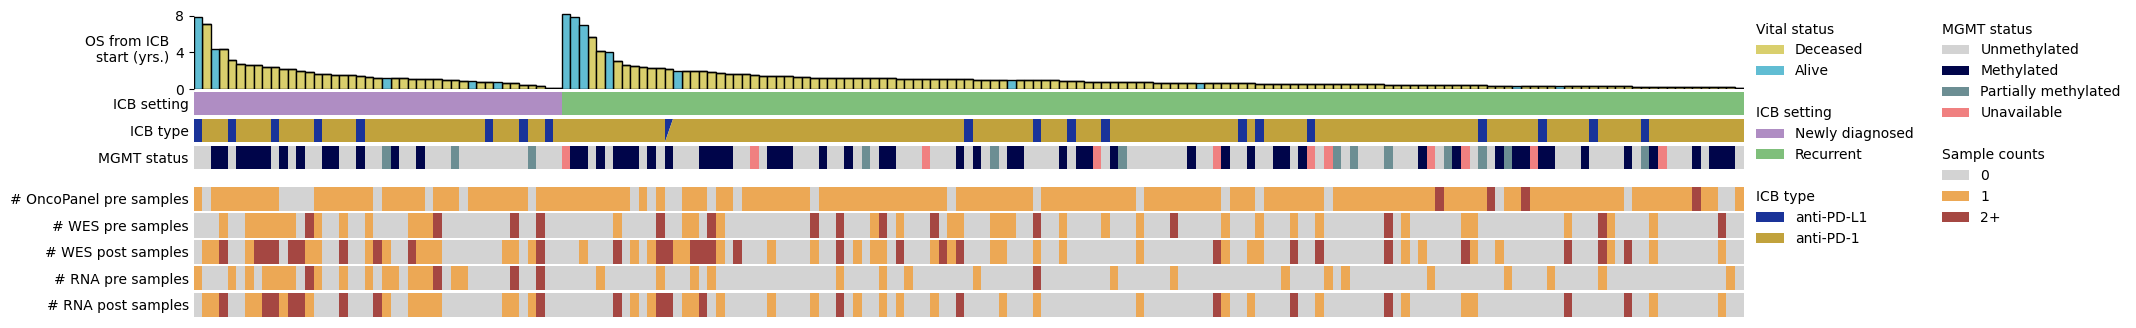

In [7]:
heights = {'Vital status': 3}

structure = [['Sample counts'], ['MGMT status', 'ICB type', 'ICB setting', 'Vital status']]

pt_comut.plot_comut(figsize = (20,4), x_padding = 0, y_padding = 0.04, tri_padding = 0,
                   hspace = 0.1, subplot_hspace = 0.01, structure = structure, heights = heights)

pt_comut.axes['Vital status'].set_ylabel('OS from ICB\nstart (yrs.)', rotation = 'horizontal', ha = 'right', va = 'center')
pt_comut.axes['Vital status'].set_yticks([0,4,8])

pt_comut.axes['Sample counts'].set_xticklabels([])

pt_comut.add_unified_legend(ncol = 2, ignored_values = [], rename = {'Absent': 'Unavailable'})

pt_comut.axes['Vital status'].get_legend().get_patches()[1].set_edgecolor(None)
pt_comut.axes['Vital status'].get_legend().get_patches()[2].set_edgecolor(None)

# Pre-ICB genomic comut

## Prepare OncoPanel variants

In [9]:
oncopanel_pts = set(sample_sheet.loc[sample_sheet['usable_oncopanel'], 'participant_id_legacy'])
len(oncopanel_pts)

155

In [10]:
oncopanel_samples_idx = sample_sheet[sample_sheet['usable_oncopanel']].groupby('participant_id_legacy')['collection_date_dfd'].idxmax()
oncopanel_samples = sample_sheet.loc[oncopanel_samples_idx, 'sample_id_legacy']

oncopanel_variants_comut = oncopanel_variants[oncopanel_variants['Sample_ID'].isin(oncopanel_samples)]
oncopanel_variants_comut = oncopanel_variants_comut.merge(sample_sheet[['sample_id_legacy', 'participant_id_legacy']], how = 'left', left_on = 'Sample_ID', right_on = 'sample_id_legacy')
oncopanel_variants_comut['sample'] = oncopanel_variants_comut['participant_id_legacy']

oncopanel_variants_comut['Patient_ID'].nunique()

151

## Prepare WES variants
The variants are already filtered to those present at the latest pre timepoint

In [11]:
wes_pts = sample_sheet.loc[sample_sheet['usable_wes'] &
                           (sample_sheet['pre_post'] == 'Pre') &
                           (~sample_sheet['participant_id_legacy'].isin(oncopanel_pts)) &
                           (sample_sheet['tumor_normal'] == 'tumor'),
                           'participant_id_legacy'].unique()

len(wes_pts)

12

In [12]:
wes_variants_comut = wes_variants[wes_variants['Patient_ID'].isin(wes_pts)]

wes_variants_comut['sample'].nunique()

12

## Combine OncoPanel and WES clinical data and variants

In [13]:
cols_keep_variants = ['sample', 'category', 'value']

comut_variants = pd.concat([oncopanel_variants_comut[cols_keep_variants],
                            wes_variants_comut[cols_keep_variants]],
                           ignore_index = True)

comut_patients = sample_sheet[(sample_sheet['pre_post'] == 'Pre') & (sample_sheet['tumor_normal'] == 'tumor') & (sample_sheet['usable_oncopanel'] | sample_sheet['usable_wes'])]['participant_id_legacy'].unique()

comut_clinical = patient_sheet[patient_sheet['sample'].isin(comut_patients)]

set(comut_patients) - set(comut_variants['sample'])

{'GBM.ICB-111', 'GBM.ICB-16', 'GBM.ICB-233', 'GBM.ICB-88'}

In [14]:
sorted_patient_list = comut_clinical.sort_values(['ICB for Newly diagnosed', 'osicb'], ascending=[True, False])['sample'].tolist()
len(sorted_patient_list)

167

## Harmonize the variant classifications

In [15]:
clean_value_dict = {
    'AMP': 'Copy gain/low amplification',
    'DEL': 'LoH',
    'DeepDEL': 'Homozygous deletion',
    'HighAMP': 'High amplification',
    'Missense': 'Missense (unknown function)',
    'Missense_Mutation': 'Missense (unknown function)',
    'Biallelic_Loss': 'Biallelic inactivation',
    'Likely Loss-of-function': 'Likely loss-of-function',
    'Likely Gain-of-function': 'Likely gain-of-function',
    'In_Frame_Del': 'In-frame indel (unknown function)',
    'GAIN': 'Copy gain/low amplification',
    'Splice_Region': 'Splice region (unknown function)',
    'Frame_Shift_Del': 'Frameshift indel (unknown function)',
    'In-frame indel': 'In-frame indel (unknown function)',
    'Amplification': 'Copy gain/low amplification',
    'FocalHighAMP': 'High amplification',
    'In_Frame_Ins': 'In-frame indel (unknown function)'
}

comut_variants['value'] = comut_variants['value'].replace(clean_value_dict)

comut_variants['value'].value_counts()

Copy gain/low amplification            392
LoH                                    209
Homozygous deletion                     94
High amplification                      60
Likely loss-of-function                 59
Gain-of-function                        40
Missense (unknown function)             40
Biallelic inactivation                  23
Likely gain-of-function                 18
Loss-of-function                        13
In-frame indel (unknown function)        8
Splice region (unknown function)         3
Frameshift indel (unknown function)      2
Name: value, dtype: int64

## Plot comut

In [16]:
pre_comut = comut.CoMut()
pre_comut.samples = sorted_patient_list

absent_mapping = {'facecolor':'none', 'edgecolor':'#D7CFBF', 'linewidth': 2}
baseline_color = 'lightgray'

# Determine gene order
gene_freqs = comut_variants.drop_duplicates(['sample', 'category']).groupby('category').count()['sample'] / len(comut_clinical)
gene_order = gene_freqs.to_frame().sort_values('sample').index.tolist()

# Add mutations
cna_colors = palettable.tableau.BlueRed_12.mpl_colors
mut_cna_mapping = {
    'Copy gain/low amplification': cna_colors[11],
    'LoH': cna_colors[7],
    'Homozygous deletion': cna_colors[0],
    'Likely loss-of-function': 'dimgrey',
    'High amplification': cna_colors[10],
    'Biallelic inactivation': cna_colors[1],
    'Missense (unknown function)': '#00e000',
    'Gain-of-function': '#d95f02',
    'Loss-of-function': 'black',
    'Likely gain-of-function': '#feb37a',
    'In-frame indel (unknown function)': 'violet',
    'Splice region (unknown function)': '#4dbd4d',
    'Frameshift indel (unknown function)': 'purple'
}

pre_comut.add_categorical_data(comut_variants,
                                     name = 'Alteration type',
                                     category_order = gene_order,
                                     mapping = mut_cna_mapping,
                                     tick_style = 'italic')

# Add mutation counts side bar
side_mapping = {'sample': baseline_color}
side_bar = gene_freqs.to_frame().reset_index()
side_bar['sample'] = 100 * side_bar['sample']
pre_comut.add_side_bar_data(side_bar,
                                 paired_name = 'Alteration type',
                                 name = 'Alteration frequency',
                                 mapping = side_mapping,
                                 xlabel = '% patients with alteration',
                                 position = 'left',
                                 bar_kwargs = {'height': 0.8})

# Add other variables

# MGMT
mgmt_df = comut_clinical.set_index('sample')[['MGMT methylated Y/N']].stack().reset_index()
mgmt_df = mgmt_df[['sample', 0]].rename(columns = {0: 'value'}).replace({'Partially': 'Partially methylated', 'Partially ': 'Partially methylated', 'Unmethylated.5': 'Unmethylated'})
mgmt_df['category'] = 'MGMT status'
mgmt_colors = palettable.scientific.sequential.Davos_3.mpl_colors
mgmt_mapping = {'Unmethylated': baseline_color, 'Partially methylated': mgmt_colors[1], 'Methylated': mgmt_colors[0], 'Absent': 'lightcoral'}
pre_comut.add_categorical_data(mgmt_df, name = 'MGMT status', mapping = mgmt_mapping)

# ICB setting
diag_df = comut_clinical.set_index('sample')[['ICB for Newly diagnosed']].stack().reset_index()
diag_df = diag_df[['sample', 0]].rename(columns = {0: 'value'}).replace({'Newly-diagnosed': 'Newly diagnosed'})
diag_df['category'] = 'ICB setting'
diag_colors = palettable.colorbrewer.diverging.PRGn_3.mpl_colors
diag_mapping = {'Newly diagnosed': diag_colors[0], 'Recurrent': diag_colors[2]}
pre_comut.add_categorical_data(diag_df, name = 'ICB setting', mapping = diag_mapping)

# TMB
tmb_df = tmb.rename(columns = {'participant_id': 'sample'})
tmb_df = tmb_df[tmb_df['sample'].isin(sorted_patient_list)]
tmb_df['value'] = tmb_df['TMB_harmonized']
tmb_df['category'] = 'TMB'
tmb_df = tmb_df[['sample', 'category', 'value']]

tmb_cmap = palettable.scientific.sequential.GrayC_20.mpl_colormap

pre_comut.add_continuous_data(tmb_df, name = 'TMB', mapping = tmb_cmap, value_range = (0, 20), cat_mapping = {'Absent': {'facecolor': 'lightcoral'}})

# OS
os_df = comut_clinical[['sample', 'Deceased', 'osicb']]
os_df['osicb'] = os_df['osicb'].div(365.25)
os_df['deceased'] = os_df.apply(lambda x: x['osicb'] if x['Deceased'] == 'Deceased' else 0, axis=1)
os_df['alive'] = os_df.apply(lambda x: 0 if x['Deceased'] == 'Deceased' else x['osicb'], axis=1)
os_df.drop(columns = ['osicb', 'Deceased'], inplace = True)
os_df.rename(columns = {'deceased': 'Deceased', 'alive': 'Alive'}, inplace = True)

vital_status_colors = palettable.scientific.diverging.Roma_4.mpl_colors
vital_status_mapping = {'Deceased': vital_status_colors[1], 'Alive': vital_status_colors[2]}

pre_comut.add_bar_data(os_df,
                             name = 'Vital status',
                             mapping = vital_status_mapping,
                             stacked = True,
                             bar_kwargs = {'edgecolor': 'black'})

/Users/merrell/miniconda3/envs/parsons/lib/python3.8/site-packages/comut/comut.py:1004: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data.loc[missing_categories, :] = 0
/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_65894/3689436425.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_df['osicb'] = os_df['osicb'].div(365.25)
/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_65894/3689436425.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

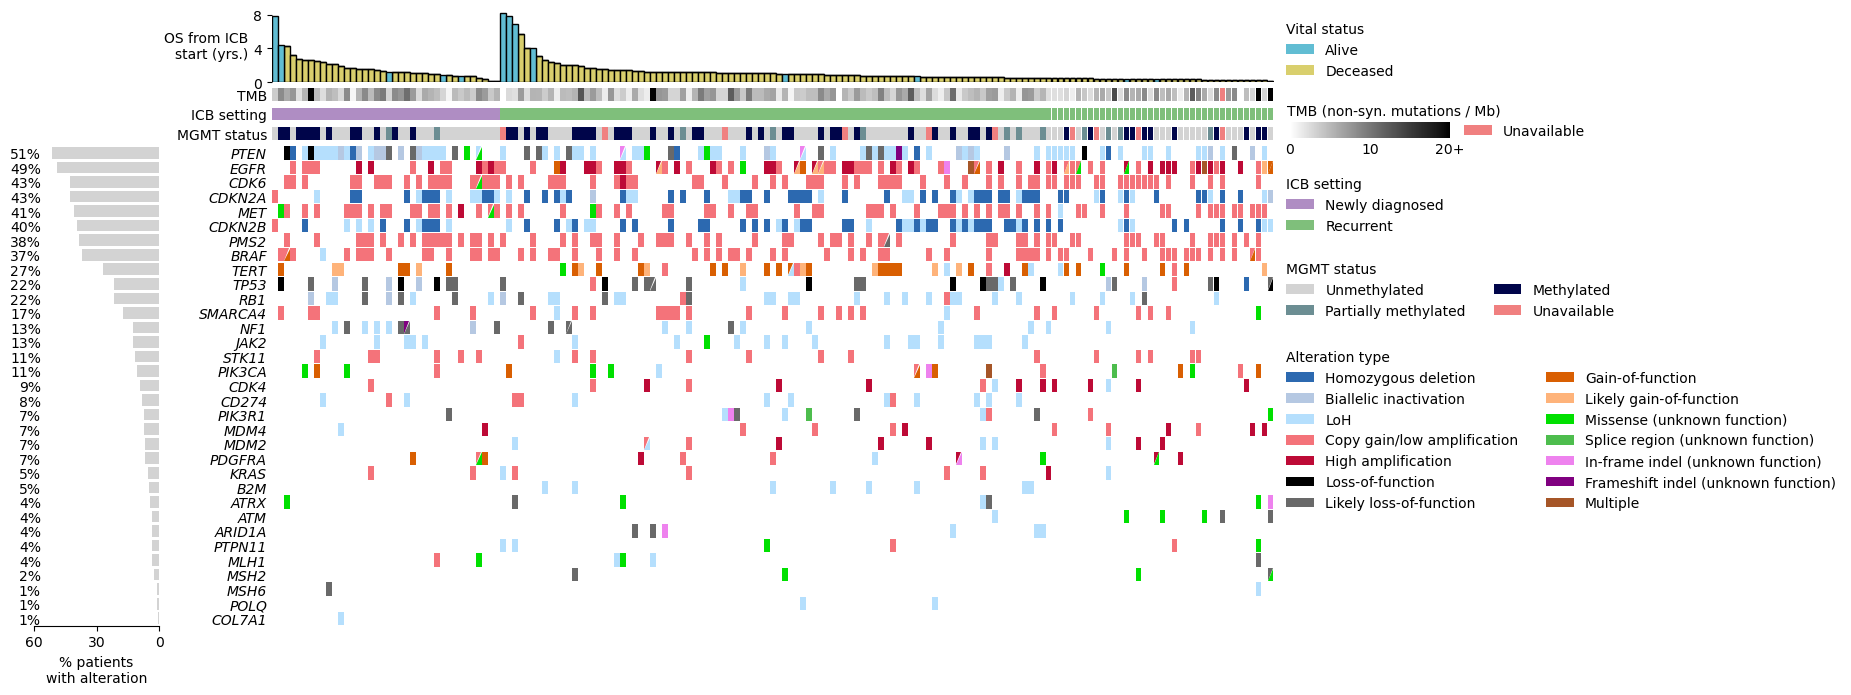

In [17]:
heights = {'Vital status': 5}

pre_comut.plot_comut(figsize = (16, 8), widths = [1, 8],
                           x_padding = 0.04, y_padding = 0.04, tri_padding = 0.04, hspace = 0.04,
                           heights = heights)

pre_comut.axes['Alteration type'].set_xticks([])

pre_comut.axes['Vital status'].set_ylabel('OS from ICB\nstart (yrs.)', rotation = 'horizontal', ha = 'right', va = 'center')
pre_comut.axes['Vital status'].set_yticks([0,4,8])

pcts = side_bar.sort_values('sample')['sample'].round().astype(int).astype(str) + '%'
pre_comut.axes['Alteration frequency'].set_yticks(np.arange(0.5, len(pcts)))
pre_comut.axes['Alteration frequency'].set_yticklabels(list(pcts))
pre_comut.axes['Alteration frequency'].tick_params(axis = 'y', pad = -5)
pre_comut.axes['Alteration frequency'].set_xticks([0,30,60])
pre_comut.axes['Alteration frequency'].set_xlabel('% patients\nwith alteration')

vital_status_legend = pre_comut.add_axis_legend(name = 'Vital status', bbox_to_anchor = (1,1), title = 'Vital status')
vital_status_legend.get_patches()[0].set_edgecolor(None)
vital_status_legend.get_patches()[1].set_edgecolor(None)

pre_comut.add_axis_legend(name = 'ICB setting', bbox_to_anchor = (1, -3), loc = 'upper left', title = 'ICB setting')

pre_comut.add_axis_legend(name = 'MGMT status', bbox_to_anchor = (1, -7.5), loc = 'upper left', title = 'MGMT status',
                          ignored_values = [], ncol = 2, order = ['Unmethylated', 'Partially methylated', 'Methylated', 'Absent'],
                          rename = {'Absent': 'Unavailable'})

alteration_type_order = ['Homozygous deletion', 'Biallelic inactivation', 'LoH', 'Copy gain/low amplification', 'High amplification',
                         'Loss-of-function', 'Likely loss-of-function', 'Gain-of-function', 'Likely gain-of-function',
                         'Missense (unknown function)', 'Splice region (unknown function)', 'In-frame indel (unknown function)', 'Frameshift indel (unknown function)']
pre_comut.add_axis_legend(name = 'Alteration type', bbox_to_anchor = (1, 0.6), title = 'Alteration type',
                          ncol = 2, order = alteration_type_order)

# TMB colormap
tmb_ax = pre_comut.figure.add_axes([0.91, 0.72, 0.1, 0.02])
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 20)
tmb_colorbar = pre_comut.figure.colorbar(matplotlib.cm.ScalarMappable(norm = norm, cmap = tmb_cmap), cax = tmb_ax, orientation = 'horizontal')
tmb_colorbar.ax.tick_params(size = 0)
tmb_colorbar.set_ticks([0,10,20])
tmb_colorbar.set_ticklabels([0,10,'20+'])
tmb_colorbar.outline.set_visible(False)
tmb_colorbar.set_label('TMB (non-syn. mutations / Mb)', labelpad = -38, x = 0.65)

# TMB unavailable for 1 pt
tmb_na_legend = [Patch(facecolor = 'lightcoral', edgecolor = None, label = 'Unavailable')]
pre_comut.axes['TMB'].legend(handles = tmb_na_legend, loc = 'center', bbox_to_anchor = (1.25, -2), frameon = False)